In [29]:
%display latex

# DIN-5034-2-Algorithmus

Der DIN-Algorithmus ist für die Berechnung der Sonneneinstrahlung in Innenräume entwickelt worden.

In [30]:
import datetime as dt

var('Zeit')
var('Stunden')

var('TagDesJahres J')
var('delta ZG')

var('LZ UTC WOZ MOZ')
var('Zeitzone ZZ')
var('Laengengrad')
var('Breitengrad')
var('Stundenwinkel')
var('Sonnenhoehe')
var('Sonnenazimut')

# Faktoren und Konstanten
Grad = pi/180
Minuten = Stunden / 60
ZahlDerTageImJahr = 365

Der **Jahreswinkel** $J$:

In [31]:
J_eqn = J == 360 * Grad * TagDesJahres / ZahlDerTageImJahr;

die **Sonnendeklination** $\delta$:

In [32]:
delta_eqn = delta == (0.3948 
                        - 23.2559 * cos(J + 9.1 * Grad)
                        - 0.3915 * cos(2 * J + 5.4 * Grad)
                        - 0.1764 * cos(3 * J + 26. * Grad)
                     ) * Grad;
delta_eqn = solve([delta_eqn, J_eqn], J, delta)[-1][-1]

An diesen Gleichungen wird bereits deutlich, dass der Algorithmus nur ungefähre Ergebnisse liefern kann, da das Konzept der Schaltjahre und Schaltsekunden nicht berücksichtigt wird.

Die sogenannte **Zeitgleichung** $ZG$ beschreibt die Abweichung der **wahren Ortszeit** $WOZ$ von der **mittleren Ortszeit** $MOZ$.
Die mittlere Ortszeit ist relativ zur **koordinierten Weltzeit** $UTC$ definiert und hängt vom **Längengrad** ab.
Mit der Angabe der **Zeitzone** $ZZ$ ist auch die **lokale Zeit** $LZ$ gegeben:

In [33]:
ZG_def = ZG == WOZ - MOZ;
ZG_eqn = ZG == (0.0066 
                    + 7.3525 * cos(J + 85.9 * Grad)
                    + 9.9359 * cos(2 * J + 108.9 * Grad)
                    + 0.3387 * cos(3 * J + 105.2 * Grad)
               ) * Minuten;
ZG_eqn = solve([ZG_eqn, J_eqn], J, ZG)[-1][-1]
MOZ_eqn = MOZ == UTC - 4 * Minuten/(1 * Grad) * Laengengrad
LZ_eqn = LZ == UTC + ZZ

Aus der Definition und einer empirischen Zeitgleichung kann die wahre Ortszeit bestimmt werden:

In [34]:
WOZ_eqn = solve([ZG_def, ZG_eqn], ZG, WOZ)[-1][-1]
WOZ_eqn = solve([WOZ_eqn, MOZ_eqn], MOZ, WOZ)[-1][-1]
WOZ_eqn = solve([WOZ_eqn, LZ_eqn], UTC, WOZ)[-1][-1]

Der **Stundenwinkel**:

In [35]:
Stundenwinkel_eqn = Stundenwinkel == (12 * Stunden - WOZ) * 15 * Grad / Stunden;
Stundenwinkel_eqn = solve([Stundenwinkel_eqn, WOZ_eqn], WOZ, Stundenwinkel)[-1][-1]

Mit der **geographischen Breite $\varphi$** lassen sich **Sonnenhöhe** und -**azimut** berechnen:

In [36]:
Sonnenhoehe_eqn = Sonnenhoehe == arcsin(
    cos(Stundenwinkel) * cos(Breitengrad) * cos(delta)
    + sin(Breitengrad) * sin(delta)
    );
Sonnenhoehe_eqn = solve([Sonnenhoehe_eqn, Stundenwinkel_eqn], Stundenwinkel, Sonnenhoehe)[-1][-1]
Sonnenhoehe_eqn = solve([Sonnenhoehe_eqn, delta_eqn], delta, Sonnenhoehe)[-1][-1]

Sonnenazimut_eqn = Sonnenazimut == (180 * Grad 
    + sign(WOZ/Stunden - 12)
    * arccos(
        (sin(Sonnenhoehe) * sin(Breitengrad) - sin(delta))
        / (cos(Sonnenhoehe) * cos(Breitengrad))
        )
    );
Sonnenazimut_eqn = solve([Sonnenazimut_eqn, Sonnenhoehe_eqn], Sonnenhoehe, Sonnenazimut)[-1][-1]
Sonnenazimut_eqn = solve([Sonnenazimut_eqn, WOZ_eqn], WOZ, Sonnenazimut)[-1][-1]
Sonnenazimut_eqn = solve([Sonnenazimut_eqn, delta_eqn], delta, Sonnenazimut)[-1][-1]

## Heutiger Sonnenweg und jetziger Sonnestand

Der heutige Sonnenweg am DBI-TZ kann mit den gegebenen Gleichungen bestimmt werden. Ein Vergleich kann mit dem Online-Angebot von [Sonnenverlauf.de](https://www.sonnenverlauf.de/#/50.93,13.35,17/2018.12.07/09:15/1/0) vorgenommen werden.

In [37]:
l = -13.35 * Grad
b = 50.93 * Grad

Sonnenhoehe_hier = Sonnenhoehe_eqn(Laengengrad=l, Breitengrad=b)
Sonnenazimut_hier = Sonnenazimut_eqn(Laengengrad=l, Breitengrad=b)
WOZ_hier = WOZ_eqn(Laengengrad=l)

Zurzeit gilt die **Mitteleuropäische Normalzeit** $MEZ$:

In [38]:
MEZ = + 1 * Stunden
MESZ = + 2 * Stunden
ZZ = MEZ

Jetzt = dt.datetime.utcnow() + dt.timedelta(hours = int(ZZ / Stunden));
Heute = (Jetzt.date() - dt.date(Jetzt.year,1,1)).days + 1;

LokaleZeit = (Jetzt.hour + Jetzt.minute / 60) * Stunden;

In [39]:
WOZ_jetzt = (WOZ_hier(TagDesJahres=Heute, LZ=LokaleZeit, ZZ=ZZ)/Stunden).expand()

Mit dem **Tag des Jahres** ergibt sich:

In [40]:
J_heute = J_eqn.rhs()
delta_heute = delta_eqn.rhs()
ZG_heute = ZG_eqn.rhs()

In [41]:
print 'Seit Beginn des Tages sind {:.1f} Stunden vergangen.'.format(float(LokaleZeit/Stunden))
print 'Heute haben wir den {}. Tag des Jahres.'.format(Heute)
print 'Die Erde hat seit Begin des Jahres {:.1f} Grad auf der Sonnenumlaufbahn zurückgelegt.'.format(
    float(J_heute(TagDesJahres=Heute) / Grad))
print 'Die Abweichung des Sonnenstandes ist heute etwa {:.1f} Grad.'.format(
    float(delta_heute(TagDesJahres=Heute)/Grad))
print 'Die Sonnenzeit weicht heute {:.1f} Minuten von der lokalen Zeit ab.'.format(
    float(ZG_heute(TagDesJahres=Heute)/Minuten))

Seit Beginn des Tages sind 0.5 Stunden vergangen.
Heute haben wir den 341. Tag des Jahres.
Die Erde hat seit Begin des Jahres 336.3 Grad auf der Sonnenumlaufbahn zurückgelegt.
Die Abweichung des Sonnenstandes ist heute etwa -22.5 Grad.
Die Sonnenzeit weicht heute 8.4 Minuten von der lokalen Zeit ab.


Über das Jahr gesehen hat die **Abweichung** folgenden Verlauf.

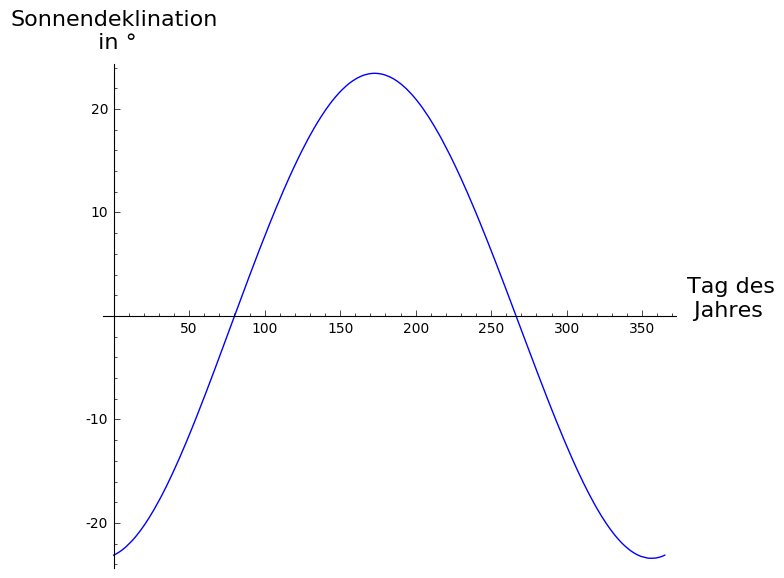

In [42]:
Deltadiagram = plot(delta_heute/Grad, 0, 365)
Deltadiagram.axes_labels(['Tag des\n Jahres',u'Sonnendeklination\n in °'])
Deltadiagram

Über das Jahr gesehen hat die **Zeitgleichung** folgenden Verlauf.

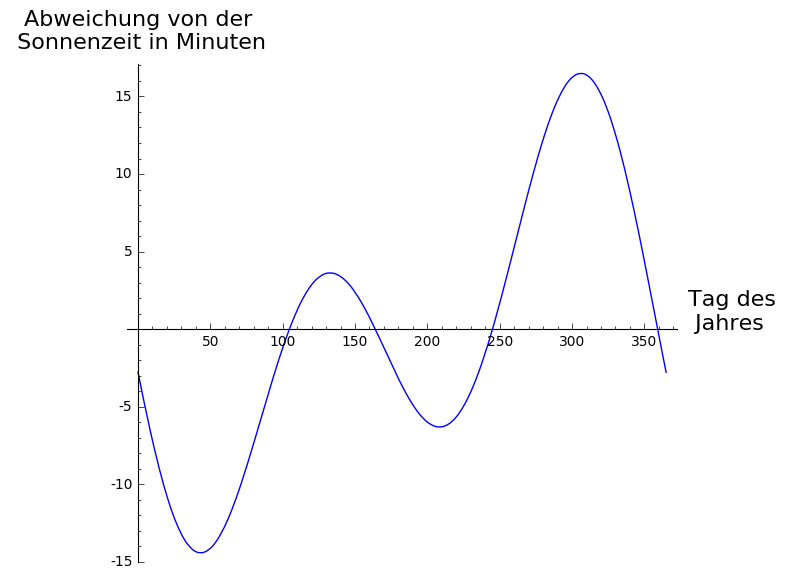

In [43]:
Zgldiagramm = plot(ZG_heute / Minuten, 0, 365)
Zgldiagramm.axes_labels(['Tag des\n Jahres','Abweichung von der\n Sonnenzeit in Minuten'])
Zgldiagramm

Für den **heute**:

In [44]:
SH = (Sonnenhoehe_hier(TagDesJahres=Heute, ZZ=ZZ, LZ=LZ*Stunden).rhs()/Grad).function(LZ)

In [45]:
Hoehe = SH(LokaleZeit/Stunden).n()
print 'Zur Zeit steht die Sonne in einem Winkel von etwa {:.1f} Grad ueber dem DBI-TZ.'.format(float(Hoehe))

Zur Zeit steht die Sonne in einem Winkel von etwa -60.8 Grad ueber dem DBI-TZ.


Natürlich können wir mit unseren Gleichungen auch den Zeitpunkt des Sonnenauf- und -untergangs berechnen, indem wir die Nulldurchgänge der Sonnenhöhe am Vormittag und Nachmittag bestimmen.

In [46]:
Sonnenaufgang = find_root(SH,0,12)
Sonnenuntergang = find_root(SH,12,24)

print 'Sonnenaufgang war etwa um {:%H:%M} und Sonnenuntergang wird etwa um {:%H:%M} sein.'.format(
    dt.datetime.utcfromtimestamp(float(Sonnenaufgang*3600))
    ,dt.datetime.utcfromtimestamp(float(Sonnenuntergang*3600))
    )

Sonnenaufgang war etwa um 08:01 und Sonnenuntergang wird etwa um 15:55 sein.


Wir können auch den Sonnenhöchststand ermitteln, indem wir die folgende Extremwertaufgabe lösen.

In [47]:
Mittag = find_root(SH.diff(LZ),Sonnenaufgang,Sonnenuntergang)
print 'Der Sonnenhöchststand ist heute um {:%H:%M}.'.format(
    dt.datetime.utcfromtimestamp(float(Mittag*3600))
)

Der Sonnenhöchststand ist heute um 11:58.


In [48]:
SA = Sonnenazimut_hier(TagDesJahres=Heute, ZZ=ZZ, LZ=LZ*Stunden).rhs()/Grad
SA = SA(Stunden=1).function(LZ) # Die sign-Funktion lässt sich sonst nicht gut vereinfachen.

Azimut = SA(LZ=LokaleZeit/Stunden).n()
print 'Zur Zeit steht die Sonne im Azimut von {:.1f} Grad.'.format(float(Azimut))

Zur Zeit steht die Sonne im Azimut von 16.2 Grad.


## Sonnenstunden
Die Definition der Luftmasse in der Vorlesung $LM = \frac{1}{\sin{\gamma_S}}$ gilt nur für große Winkel $\gamma_S > 30\, °$.
Diese Bedingung ist in unseren Breitengraden selten der Fall.
Deshalb verwenden wir hier eine [Formel](http://www.pveducation.org/pvcdrom/2-properties-sunlight/air-mass),
die die Krümmung der Erdoberfläche berücksichtigt.

In [49]:
aspectratio = 3
durchmesser = 10
StundenListe = srange(12-6, 12+10, 2)

# Sonnenweg
Sonnenwegdiagram = parametric_plot( (SA(Zeit), SH(Zeit)), (Zeit, Sonnenaufgang, Sonnenuntergang ) )
# Punkte für Stunden
SonnenwegdiagramStunden = point( [(SA(Zeit), SH(Zeit)) for Zeit in StundenListe] )
# Symbol für die Sonne
Sonne = ellipse((Azimut,Hoehe),durchmesser,durchmesser / aspectratio,rgbcolor='yellow', fill=True, legend_label='Die Sonne')

# Grafikobjekt
G = Graphics()
G += Sonnenwegdiagram
G += SonnenwegdiagramStunden
# Beschriftung für Stunden
for Zeit in StundenListe:
    if SH(Zeit) > -5:
        da = 3
        if Zeit < 12: da = -3
        G += text('{}'.format(Zeit),(SA(Zeit) + da, SH(Zeit) + 6 / aspectratio))
G += Sonne

G.axes_range(0,360,0,60)
G.axes_labels(['Azimut',u'Höhe'])
G.set_aspect_ratio(aspectratio)

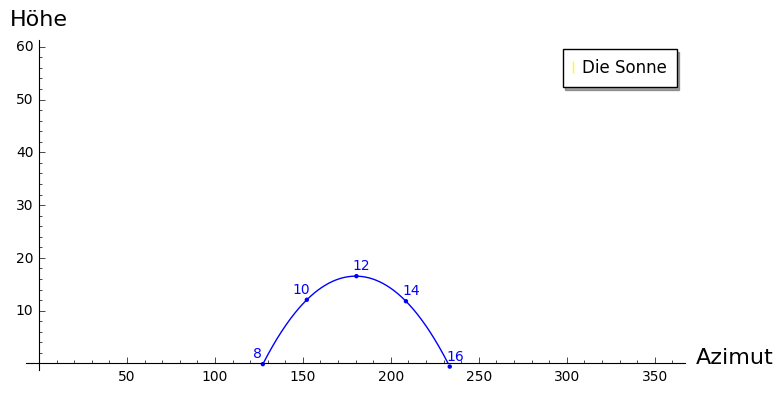

In [50]:
G.show()

In [51]:
SH = Sonnenhoehe_hier(ZZ=ZZ, LZ=LZ*Stunden).rhs()/Grad
ErsterTag = 1
Tage = 365
Sonnenstunden = 0
Luftmasse = 0
# Formel aus der Vorlesung
LM = (1 / sin(SH*Grad)).factor()
# Alternative Formel
LM = (1 / (cos((90 - SH) * Grad) + 0.50572 * (6.07995 + SH)**(-1.6364))).factor()
#print LM
Delta = 0.01
for Heute in srange(ErsterTag,ErsterTag + Tage,1):
    Sonnenaufgang = find_root(SH(TagDesJahres=Heute),0,12)
    Sonnenuntergang = find_root(SH(TagDesJahres=Heute),12,24)
    Sonnenstunden += float(Sonnenuntergang - Sonnenaufgang - 2 * Delta)
    Luftmasse += \
        numerical_integral(LM(TagDesJahres=Heute),Sonnenaufgang + Delta,Sonnenuntergang - Delta)[0] \
        / float(Sonnenuntergang - Sonnenaufgang - 2 * Delta)

In Deutschland wird von einer Sonnenscheindauer von $1000$ Stunden pro Jahr ausgegangen.

In [52]:
print 'An diesem Ort gibt es {:.0f} Stunden Tageslicht im Jahr.'.format(Sonnenstunden)
print 'Die mittlere tägliche Sonnenscheindauer beträgt {:.2f} Stunden.'.format(Sonnenstunden / Tage)
print 'Die mittlere Luftmasse beträgt {:.2f}.'.format(Luftmasse / Tage) 

An diesem Ort gibt es 4398 Stunden Tageslicht im Jahr.
Die mittlere tägliche Sonnenscheindauer beträgt 12.05 Stunden.
Die mittlere Luftmasse beträgt 4.88.


Um auf die Sonnenscheindauer zu kommen, wird die gleiche Auswertung für die Mittagsstunden wiederholt.

In [53]:
SH = Sonnenhoehe_hier(ZZ=ZZ, LZ=LZ*Stunden).rhs()/Grad
ErsterTag = 1
Tage = 365
Sonnenstunden = 0
Luftmasse = 0
# Formel aus der Vorlesung
LM = (1 / sin(SH*Grad)).factor()
# Alternative Formel
LM = (1 / (cos((90 - SH) * Grad) + 0.50572 * (6.07995 + SH)**(-1.6364))).factor()
#print LM
Delta = 0.01
for Heute in srange(ErsterTag,ErsterTag + Tage,1):
    Sonnenaufgang = find_root(SH(TagDesJahres=Heute),0,12)
    Sonnenuntergang = find_root(SH(TagDesJahres=Heute),12,24)
    Mittag = find_root(SH(TagDesJahres=Heute).diff(LZ),Sonnenaufgang,Sonnenuntergang)
    Mittagsstunden = (Sonnenuntergang - Sonnenaufgang) / 4
    Anfangszeit = Mittag - Mittagsstunden / 2
    Endzeit = Mittag + Mittagsstunden / 2
    Sonnenstunden += float(Mittagsstunden)
    Luftmasse += \
        numerical_integral(LM(TagDesJahres=Heute),Anfangszeit,Endzeit)[0] \
        / float(Mittagsstunden)

In [54]:
print 'An diesem Ort gibt es {:.0f} Stunden Sonnenschein im Jahr.'.format(Sonnenstunden)
print 'Die mittlere tägliche Sonnenscheindauer beträgt {:.2f} Stunden.'.format(Sonnenstunden / Tage)
print 'Die mittlere Luftmasse beträgt {:.2f}.'.format(Luftmasse / Tage) 

An diesem Ort gibt es 1101 Stunden Sonnenschein im Jahr.
Die mittlere tägliche Sonnenscheindauer beträgt 3.02 Stunden.
Die mittlere Luftmasse beträgt 1.97.


In [55]:
Heute = 1 #364/2
Sonnenaufgang = find_root(SH(TagDesJahres=Heute),0,12)
Sonnenuntergang = find_root(SH(TagDesJahres=Heute),12,24)
Mittag = find_root(SH(TagDesJahres=Heute).diff(LZ),Sonnenaufgang,Sonnenuntergang)
LM = (1 / (cos((90 - SH) * Grad) + 0.50572 * (6.07995 + SH)**(-1.6364))).factor()
LM = LM(TagDesJahres = Heute).factor()
print '----------------------'
print 'Zeit\t LM\t SH'
print 'in h\t -\t in °'
print '---------------------'
for Zeit in srange(Sonnenaufgang+0.1,Sonnenuntergang):
    print '{:4.1f}\t{:4.1f}\t{:4.1f}'.format(float(Zeit), float(LM(LZ=Zeit)), float(SH(TagDesJahres=Heute,LZ=Zeit)))
print '---------------------'

----------------------
Zeit	 LM	 SH
in h	 -	 in °
---------------------
 8.4	28.8	 0.7
 9.4	 7.4	 7.3
10.4	 4.6	12.3
11.4	 3.7	15.3
12.4	 3.6	16.0
13.4	 4.0	14.3
14.4	 5.3	10.5
15.4	10.7	 4.8
---------------------


----